In [20]:
import numpy as np

import hdbscan

import logging

import matplotlib.pyplot as plt

In [2]:
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [209]:
%autoreload 2
from src.MapData import MapData
from src.plotting_functions import plot_embedding

In [4]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

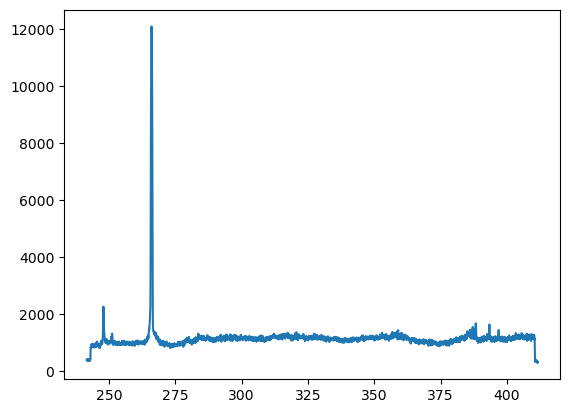

In [9]:
map_data.plot_random_spectrum()

In [10]:
map_data.load_all_data()

In [12]:
full_emissivities = map_data.spectra.sum(axis=1)

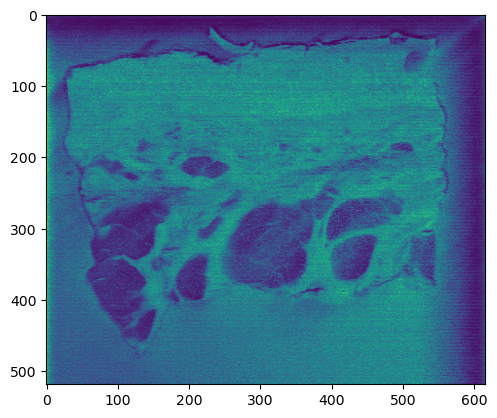

In [18]:
full_emissivities = full_emissivities.reshape(map_data.map_dimensions[::-1])
full_emissivities[::2,:] = full_emissivities[::2,::-1]

plt.imshow(full_emissivities)

In [201]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [131]:
PC_COUNT = 18

pca_model = PCA(n_components=PC_COUNT)

In [182]:
STEP_SIZE = 20

dist_matrix = cosine_distances(map_data.spectra[::STEP_SIZE,:])
dist_matrix = dist_matrix.astype(np.float64)

pca_scores = pca_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

In [175]:
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_embedding = tsne_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

In [202]:
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.5)
umap_results = umap_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

In [208]:
%%writefile ./src/plotting_functions.py

import numpy as np
import matplotlib.pyplot as plt

def plot_embedding(
    embedded_data,
    explained_variances=None,
    colors=None
):
    if explained_variances is not None: explained_variances *= 100
    pc_count = embedded_data.shape[1]

    if colors is None: colors = [1] * len(embedded_data)

    col_count = np.min([
        3,
        int(np.sqrt(pc_count // 2))
    ])
    row_count = np.min([
        3, 
        int(np.sqrt(pc_count // 2))
    ])

    fig, ax = plt.subplots(
        ncols=col_count,
        nrows=row_count
    )

    if col_count * row_count == 1:
        ax.scatter(
            x=embedded_data[:,0],
            y=embedded_data[:,1],
            s=.5,
            alpha=.2,
            c=colors
        )

        x_lab = f'PC1 ({explained_variances[0]:.2f} %)' if explained_variances is not None else f'latent dim. 1'
        y_lab = f'PC2 ({explained_variances[1]:.2f} %)' if explained_variances is not None else f'latent dim. 2'

        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.set_xticks([])
        ax.set_yticks([])

    elif col_count * row_count >= 2:
        for pc_ndx in range(col_count * row_count):
            ax[pc_ndx // col_count,pc_ndx % row_count].scatter(
                x=embedded_data[:,pc_ndx*2],
                y=embedded_data[:,pc_ndx*2+1],
                s=.5,
                alpha=.2,
                c=colors
            )

            x_lab = f'PC{pc_ndx*2 + 1} ({explained_variances[pc_ndx*2]:.2f} %)' if explained_variances is not None else f'latent dim. {pc_ndx*2 + 1}'
            y_lab = f'PC{pc_ndx*2 + 2} ({explained_variances[pc_ndx*2 + 1]:.2f} %)' if explained_variances is not None else f'latent dim. {pc_ndx*2 + 2}'

            ax[pc_ndx // col_count,pc_ndx % row_count].set_xlabel(x_lab)
            ax[pc_ndx // col_count,pc_ndx % row_count].set_ylabel(y_lab)
            ax[pc_ndx // col_count,pc_ndx % row_count].set_xticks([])
            ax[pc_ndx // col_count,pc_ndx % row_count].set_yticks([])

    fig.tight_layout()
    fig.show()

Overwriting ./src/plotting_functions.py


C:\Users\kepes\AppData\Local\Temp\ipykernel_21088\3606788301.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


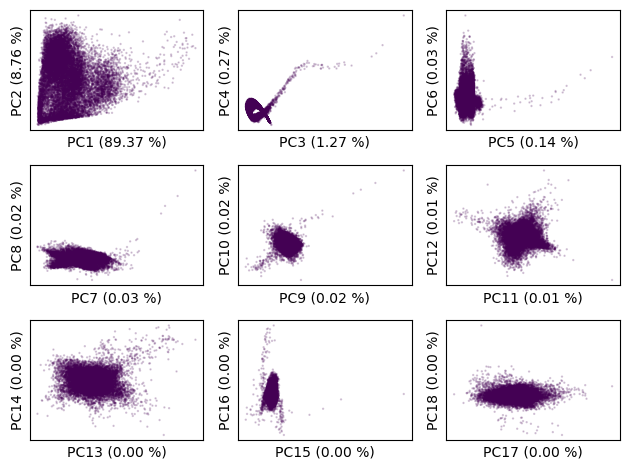

In [188]:
plot_embedding(
    pca_scores,
    pca_model.explained_variance_ratio_.copy()
)

In [119]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    alpha=.01,
    approx_min_span_tree=True,
    gen_min_span_tree=False, 
    leaf_size=20,
    metric='precomputed',
    min_cluster_size=50,
    min_samples=30,
    p=None,
    core_dist_n_jobs=3
)

clusterer.fit(dist_matrix)

HDBSCAN(alpha=0.01, core_dist_n_jobs=3, leaf_size=20, metric='precomputed',
        min_cluster_size=50, min_samples=30)

In [120]:
plot_labels = clusterer.labels_.copy()

counts, bins = np.histogram(
    plot_labels,
    bins=np.arange(-1,len(
        np.unique(plot_labels)
    ))
)

main_cluster_id = bins[np.argmax(counts)]

print(
    f'the most populous cluster is {main_cluster_id}'
)

main_cluster_cond = clusterer.labels_ == main_cluster_id

the most populous cluster is 2


C:\Users\kepes\AppData\Local\Temp\ipykernel_21088\1713984232.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


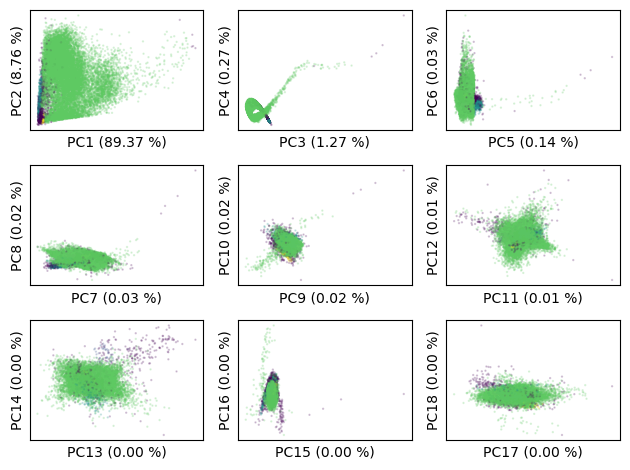

In [199]:
plot_embedding(
    pca_scores,
    explained_variances=pca_model.explained_variance_ratio_.copy(),
    colors=plot_labels
)

C:\Users\kepes\AppData\Local\Temp\ipykernel_21088\1713984232.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


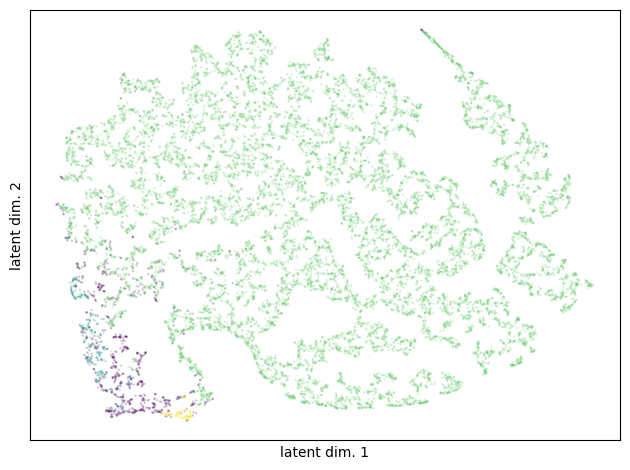

In [200]:
plot_embedding(
    tsne_embedding,
    colors=plot_labels
)

c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


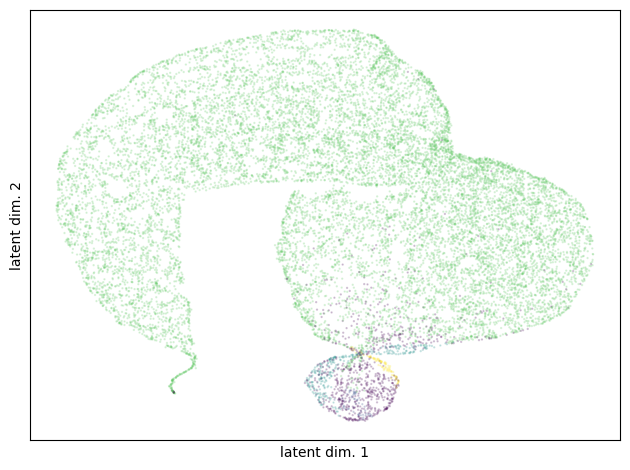

In [210]:
plot_embedding(
    umap_results,
    colors=plot_labels
)

In [169]:
plot_data = np.zeros_like(
    np.arange(map_data.metadata.get('spectra'))
).astype(np.float32)
# plot_data += 2
plot_data[::STEP_SIZE] = plot_labels
plot_data = np.ma.array(plot_data, mask=np.isnan(plot_data))

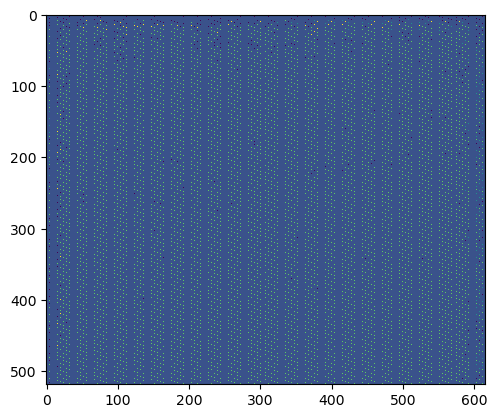

In [171]:
plot_data = plot_data.reshape(map_data.map_dimensions[::-1])
plot_data[::2,:] = plot_data[::2,::-1]

plt.imshow(plot_data,interpolation_stage='data', interpolation='none')

In [112]:
plot_data

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, -1.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)